<a href="https://colab.research.google.com/github/aditya112346/Assignment-Zeotap-/blob/main/Aditya_Garg_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

# Load the datasets
transactions_path = '/content/Transactions.csv'
products_path = '/content/Products.csv'
customers_path = '/content/Customers.csv'

transactions = pd.read_csv(transactions_path)
products = pd.read_csv(products_path)
customers = pd.read_csv(customers_path)

# Display the first few rows of each dataset
transactions_head = transactions.head()
products_head = products.head()
customers_head = customers.head()

transactions_info = transactions.info()
products_info = products.info()
customers_info = customers.info()

transactions_head, products_head, customers_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
<class 'pan

(  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   CustomerID        CustomerName         Region  SignupDate

In [3]:
# Convert date columns to datetime for proper analysis
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

# Merging datasets for comprehensive analysis
merged_data = transactions.merge(products, on='ProductID').merge(customers, on='CustomerID')

# Summary statistics
transactions_summary = transactions.describe(include='all')
products_summary = products.describe(include='all')
customers_summary = customers.describe(include='all')

# Aggregations for insights
# 1. Top 5 products by total sales value
top_products = merged_data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(5)

# 2. Sales distribution by region
sales_by_region = merged_data.groupby('Region')['TotalValue'].sum()

# 3. Category-wise sales contribution
category_sales = merged_data.groupby('Category')['TotalValue'].sum()

# 4. Monthly sales trend
merged_data['Month'] = merged_data['TransactionDate'].dt.to_period('M')
monthly_sales_trend = merged_data.groupby('Month')['TotalValue'].sum()

# 5. Top regions by customer count
customer_count_by_region = customers['Region'].value_counts()

top_products, sales_by_region, category_sales, monthly_sales_trend, customer_count_by_region

(ProductName
 ActiveWear Smartwatch    39096.97
 SoundWave Headphones     25211.64
 SoundWave Novel          24507.90
 ActiveWear Jacket        22712.56
 ActiveWear Rug           22314.43
 Name: TotalValue, dtype: float64,
 Region
 Asia             152074.97
 Europe           166254.63
 North America    152313.40
 South America    219352.56
 Name: TotalValue, dtype: float64,
 Category
 Books          192147.47
 Clothing       166170.66
 Electronics    180783.50
 Home Decor     150893.93
 Name: TotalValue, dtype: float64,
 Month
 2023-12     3769.52
 2024-01    66376.39
 2024-02    51459.27
 2024-03    47828.73
 2024-04    57519.06
 2024-05    64527.74
 2024-06    48771.18
 2024-07    71366.39
 2024-08    63436.74
 2024-09    70603.75
 2024-10    47063.22
 2024-11    38224.37
 2024-12    59049.20
 Freq: M, Name: TotalValue, dtype: float64,
 Region
 South America    59
 Europe           50
 North America    46
 Asia             45
 Name: count, dtype: int64)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Prepare customer and transaction data for modeling
# Aggregating purchase history by customer and product categories
merged_data = transactions.merge(products, on='ProductID').merge(customers, on='CustomerID')
category_sales_per_customer = merged_data.groupby(['CustomerID', 'Category'])['TotalValue'].sum().unstack(fill_value=0)

# Merge with customer details
customer_data = customers.set_index('CustomerID').join(category_sales_per_customer, how='left').fillna(0)

# Scale the data for similarity calculations
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data.iloc[:, 3:])

# Calculate cosine similarity between customers
similarity_matrix = cosine_similarity(customer_data_scaled)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_data.index, columns=customer_data.index)

# Generate lookalike recommendations for the first 20 customers
lookalike_map = {}
for customer_id in customer_data.index[:20]:
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]
    lookalike_map[customer_id] = list(zip(similar_customers.index, similar_customers.values))

# Convert to Lookalike.csv format
lookalike_df = pd.DataFrame({
    'CustomerID': [customer for customer, recs in lookalike_map.items() for _ in recs],
    'LookalikeID': [rec[0] for recs in lookalike_map.values() for rec in recs],
    'Score': [rec[1] for recs in lookalike_map.values() for rec in recs]
})

# Save the result
lookalike_csv_path = '/content/Lookalike.csv'
lookalike_df.to_csv(lookalike_csv_path, index=False)

lookalike_csv_path

'/content/Lookalike.csv'

Customer Segmentation / Clustering

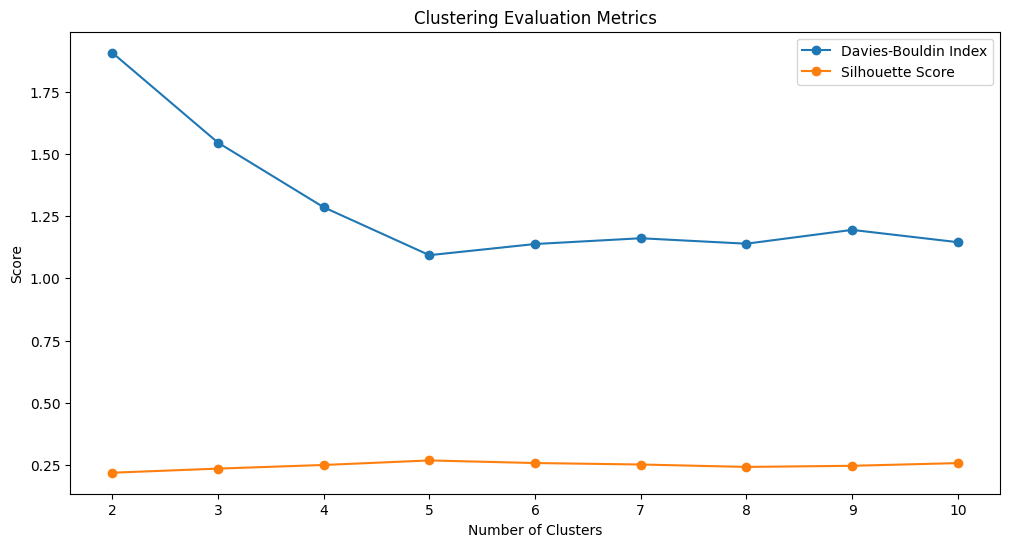

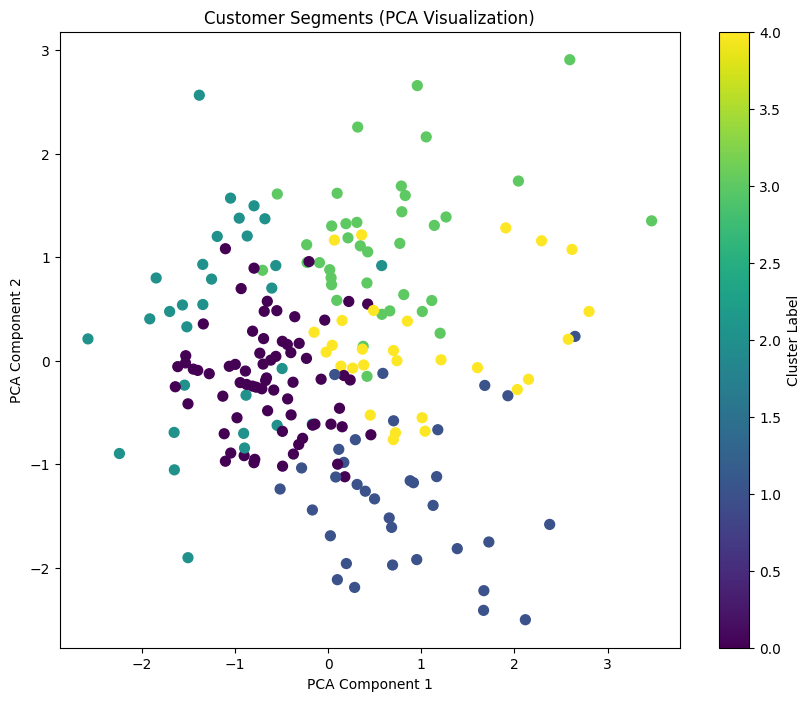

(5, 1.0928954746276403, 0.2686658087576492)

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt

# Combine profile and transaction data for clustering
segmentation_data = customer_data.iloc[:, 3:]  # Transaction history (Category sales)
segmentation_data_scaled = scaler.fit_transform(segmentation_data)  # Standardize the data

# Finding the optimal number of clusters (2 to 10) using Davies-Bouldin Index
db_index_scores = []
silhouette_scores = []
cluster_range = range(2, 11)
kmeans_models = {}

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(segmentation_data_scaled)
    db_index = davies_bouldin_score(segmentation_data_scaled, cluster_labels)
    silhouette = silhouette_score(segmentation_data_scaled, cluster_labels)
    db_index_scores.append(db_index)
    silhouette_scores.append(silhouette)
    kmeans_models[n_clusters] = kmeans

# Select the optimal model with the lowest Davies-Bouldin Index
optimal_clusters = cluster_range[np.argmin(db_index_scores)]
optimal_kmeans = kmeans_models[optimal_clusters]
final_labels = optimal_kmeans.labels_

# Visualizing Davies-Bouldin Index and Silhouette Score
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, db_index_scores, marker='o', label='Davies-Bouldin Index')
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Clustering Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

# Add clustering labels to customer data
customer_data['Cluster'] = final_labels

# Visualizing clusters using PCA for dimensionality reduction (2D plot)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(segmentation_data_scaled)
customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(customer_data['PCA1'], customer_data['PCA2'], c=final_labels, cmap='viridis', s=50)
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Report clustering metrics
db_index_optimal = db_index_scores[np.argmin(db_index_scores)]
silhouette_optimal = silhouette_scores[np.argmin(db_index_scores)]

optimal_clusters, db_index_optimal, silhouette_optimal
